In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Get the original magma colormap
magma = plt.cm.get_cmap('magma', 256)

# Convert to array and prepend grey
magma_colors = magma(np.linspace(0, 1, 256))
grey = np.array([[0.8, 0.8, 0.8, 1.0]])  # RGBA for light grey

# Combine: grey for near-zero, then rest of magma
new_colors = np.vstack((grey, magma_colors[20:]))  # skip darkest part of magma
custom_cmap1 = ListedColormap(new_colors)

C:\Users\아이디어패드\AppData\Local\Temp\ipykernel_16060\2828510362.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  magma = plt.cm.get_cmap('magma', 256)


In [3]:
def preprocess_adata(adata):

    # Ensure unique gene names to prevent reindexing errors
    adata.var_names_make_unique()
    
    # Mark mitochondrial and ribosomal genes
    adata.var['mt'] = adata.var_names.str.startswith("MT-")
    
    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(
        adata,
        qc_vars=['mt'],
        percent_top=None,
        log1p=False,
        inplace=True
    )

    # normalize
    sc.pp.normalize_total(adata, target_sum=10000)
    sc.pp.log1p(adata)
    
    return adata

In [4]:
# TI_STR
adata_TI = sc.read_mtx('TI_STR.scp.matrix.mtx').T
genes_TI = pd.read_csv('TI_STR.scp.features.tsv', header=None, sep='\t')
adata_TI.var.index = genes_TI[1].values
barcodes_TI = pd.read_csv('TI_STR.scp.barcodes.tsv', header=None, sep='\t')
adata_TI.obs.index = barcodes_TI[0].values

In [5]:
adata_TI = preprocess_adata(adata_TI)
gadata_TI= adata_TI.copy()

In [6]:
adata_TI.obs['Sample.ID'] = adata_TI.obs_names.str.split('_').str[0]

In [7]:
samples_df = pd.read_excel('mmc2.xlsx', sheet_name='Samples')
samples_info = pd.DataFrame({
    "Sample.ID": samples_df.iloc[:, 0],   # Sample.ID
    "Condition": samples_df.iloc[:, 2]    # Condition (Heal, NonI, Infl)
})

In [9]:
sample_to_condition = dict(zip(samples_info['Sample.ID'], samples_info['Condition']))
adata_TI.obs['condition'] = adata_TI.obs['Sample.ID'].map(sample_to_condition)

In [10]:
sc.pp.highly_variable_genes(adata_TI, n_top_genes = 2500)
adata_TI.raw = adata_TI.copy()
adata_TI = adata_TI[:, adata_TI.var.highly_variable].copy()

C:\Anaconda3\envs\NIM_Kim\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


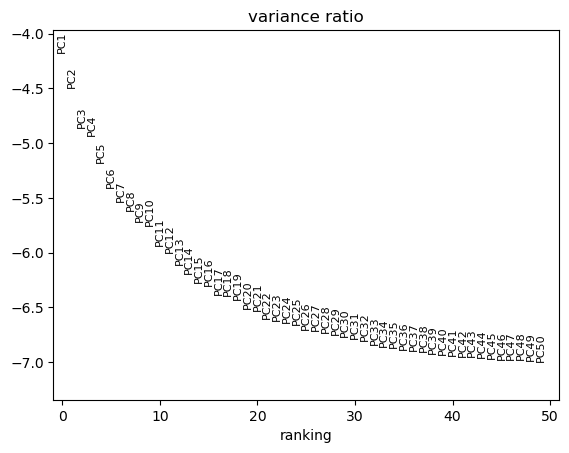

In [11]:
sc.pp.scale(adata_TI, max_value=10)
sc.tl.pca(adata_TI, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_TI, log=True, n_pcs = 50)

In [13]:
sc.external.pp.harmony_integrate(adata_TI, key='Sample.ID', max_iter_harmony = 20)
sc.pp.neighbors(adata_TI, n_neighbors = 30, n_pcs = 50, use_rep='X_pca_harmony')
sc.tl.umap(adata_TI)

2025-07-22 15:24:20,035 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-07-22 15:24:35,080 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-07-22 15:24:35,846 - harmonypy - INFO - Iteration 1 of 20
2025-07-22 15:26:01,629 - harmonypy - INFO - Iteration 2 of 20
2025-07-22 15:27:31,259 - harmonypy - INFO - Iteration 3 of 20
2025-07-22 15:28:58,356 - harmonypy - INFO - Iteration 4 of 20
2025-07-22 15:30:28,008 - harmonypy - INFO - Iteration 5 of 20
2025-07-22 15:31:54,825 - harmonypy - INFO - Iteration 6 of 20
2025-07-22 15:33:04,836 - harmonypy - INFO - Iteration 7 of 20
2025-07-22 15:34:09,812 - harmonypy - INFO - Iteration 8 of 20
2025-07-22 15:35:07,255 - harmonypy - INFO - Iteration 9 of 20
2025-07-22 15:36:19,234 - harmonypy - INFO - Iteration 10 of 20
2025-07-22 15:37:11,440 - harmonypy - INFO - Iteration 11 of 20
2025-07-22 15:38:23,050 - harmonypy - INFO - Converged after 11 iterations
C:\Anaconda3\envs\NIM_Kim\Lib\site-packages\tqdm\

C:\Users\아이디어패드\AppData\Local\Temp\ipykernel_16060\2373757473.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_TI, resolution = 1.0)


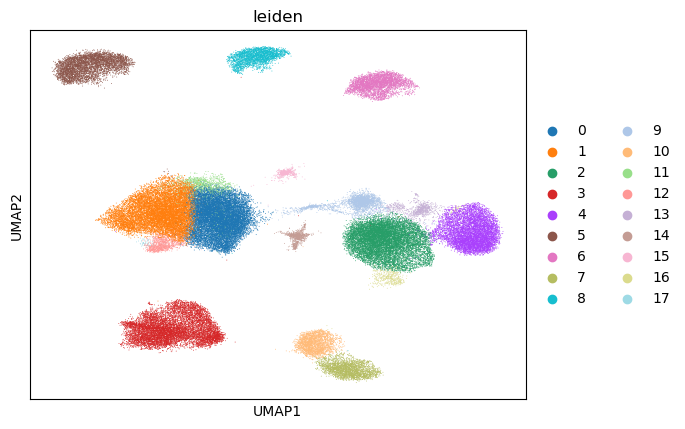

In [14]:
sc.tl.leiden(adata_TI, resolution = 1.0)
sc.pl.umap(adata_TI, color=['leiden'])

In [15]:
marker_gene = pd.read_excel("mmc3.xlsx")
stromal_marker = marker_gene[marker_gene["Compartment"] == "Stromal"]
stromal_marker = stromal_marker[['Cell subset name', 'Markers']]

In [19]:
import ast
stromal_marker['Markers'] = stromal_marker['Markers'].apply(ast.literal_eval)

In [20]:
stromal_marker_long = stromal_marker.explode('Markers')
stromal_marker_long.rename(columns={'Cell subset name': 'cell_type', 'Markers': 'gene'}, inplace=True)

In [21]:
def auto_celltype_annotation(adata, marker_df, groupby='leiden', top_n=500):
    sc.tl.rank_genes_groups(adata, groupby=groupby, method='wilcoxon', use_raw=True)
    clusters = adata.obs[groupby].unique()
    cluster_to_type = {}

    for cluster in clusters:
        degs = sc.get.rank_genes_groups_df(adata, group=cluster, pval_cutoff=None)
        top_genes = set(degs['names'].head(top_n))  # top_n 늘려줌

        scores = {}
        matched_genes = {}

        for cell_type in marker_df['cell_type'].unique():
            markers = set(marker_df.loc[marker_df['cell_type'] == cell_type, 'gene'])
            matched = top_genes & markers
            scores[cell_type] = len(matched)
            matched_genes[cell_type] = matched

        best_match = max(scores, key=scores.get)
        cluster_to_type[cluster] = best_match

        print(f"\n[Cluster {cluster}]")
        print(f"  Best match: {best_match}")
        print(f"  Matched marker genes: {', '.join(matched_genes[best_match]) if matched_genes[best_match] else 'None'}")

    adata.obs['cell_type'] = adata.obs[groupby].map(cluster_to_type)
    return cluster_to_type

In [22]:
cluster_to_type = auto_celltype_annotation(adata_TI, stromal_marker_long, groupby='leiden', top_n=50)
print(cluster_to_type)


[Cluster 1]
  Best match: Fibroblasts KCNN3+ LY6H+ 
  Matched marker genes: DPT, C7

[Cluster 16]
  Best match: Endothelial cells CD36+ 
  Matched marker genes: TMEM88, RBP7, CD36, PLVAP

[Cluster 3]
  Best match: Myofibroblasts HHIP+ NPNT+ 
  Matched marker genes: ACTG2, MYH11, TAGLN, HHIP, ACTA2, NPNT

[Cluster 0]
  Best match: Fibroblasts ADAMDEC1+ 
  Matched marker genes: CCL11, HAPLN1, ADAMDEC1, CCL13

[Cluster 11]
  Best match: Activated fibroblasts CCL19+ ADAMADEC1+ 
  Matched marker genes: CCL19, ADAMDEC1

[Cluster 5]
  Best match: Fibroblasts NPY+ SLITRK6+ 
  Matched marker genes: NSG1, F3, EDNRB, NPY

[Cluster 4]
  Best match: Endothelial cells DARC+ 
  Matched marker genes: SELE, GPR126, C2CD4B, CPE, DARC

[Cluster 2]
  Best match: Endothelial cells CD36+ 
  Matched marker genes: RBP7, PLVAP

[Cluster 14]
  Best match: Activated fibroblasts CCL19+ ADAMADEC1+ 
  Matched marker genes: None

[Cluster 8]
  Best match: Glial cells 
  Matched marker genes: CDH19, SCN7A, S100B, NR

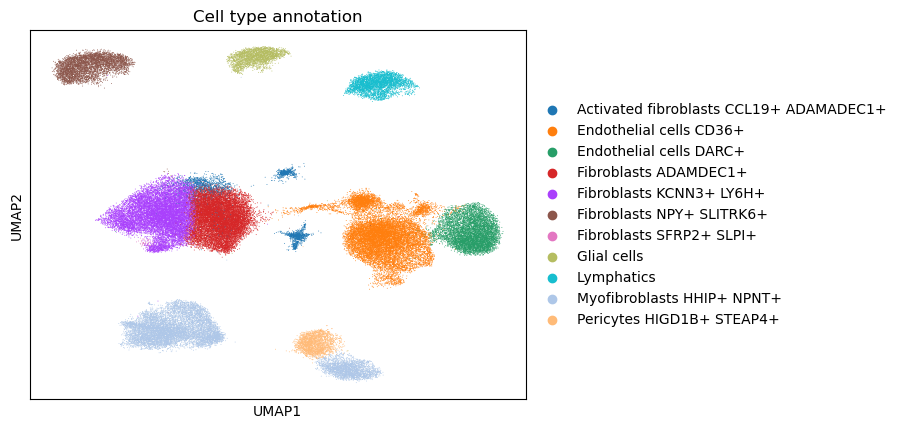

In [23]:
sc.pl.umap(adata_TI, color=['cell_type'], legend_loc='right margin', title='Cell type annotation')

In [28]:
marker_genes = stromal_marker_long['gene'].unique().tolist()

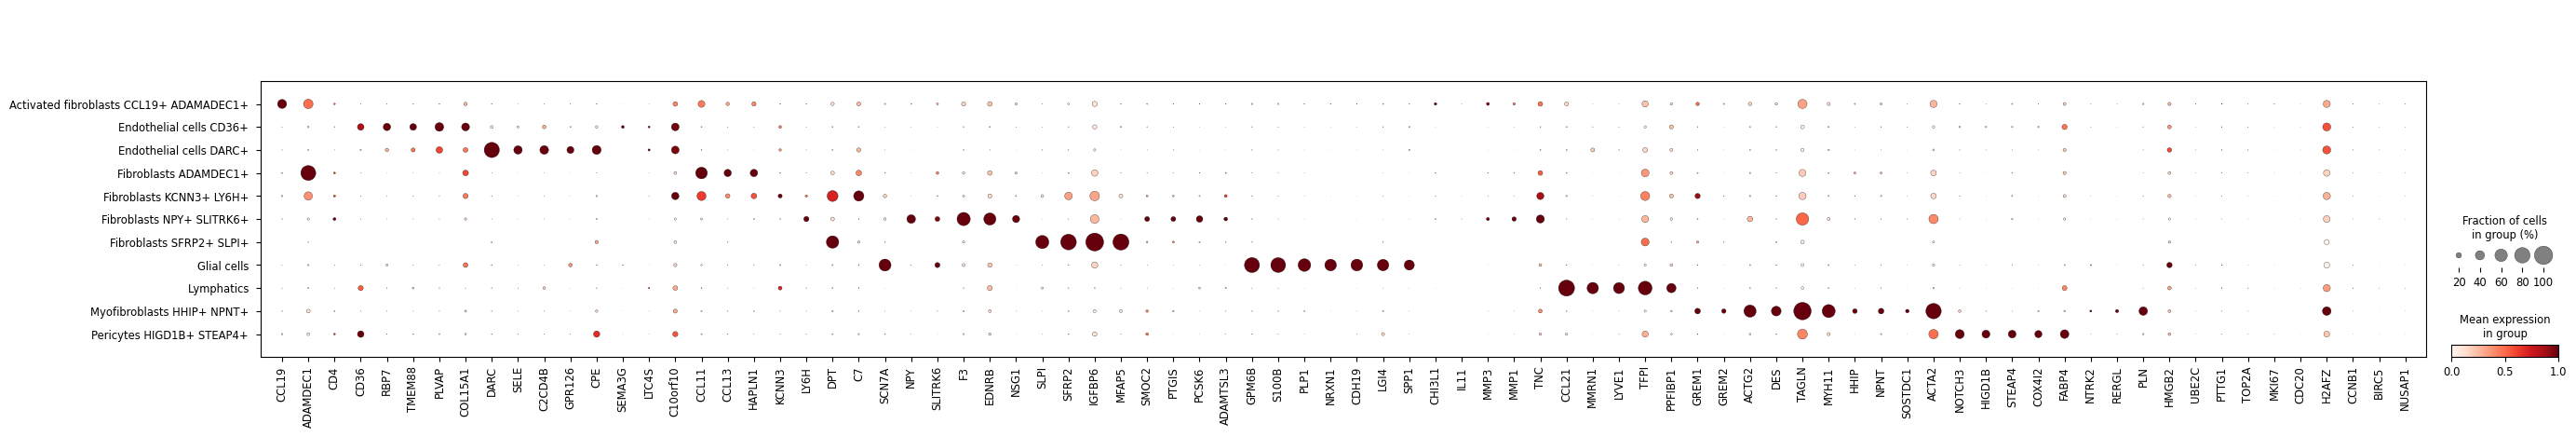

In [29]:
sc.pl.dotplot(
    adata_TI,
    var_names=marker_genes,
    groupby='cell_type',  # 또는 'leiden'
    standard_scale='var',  # 클러스터별로 발현 스케일링
    dendrogram=False
)

TI_STR_GLIA

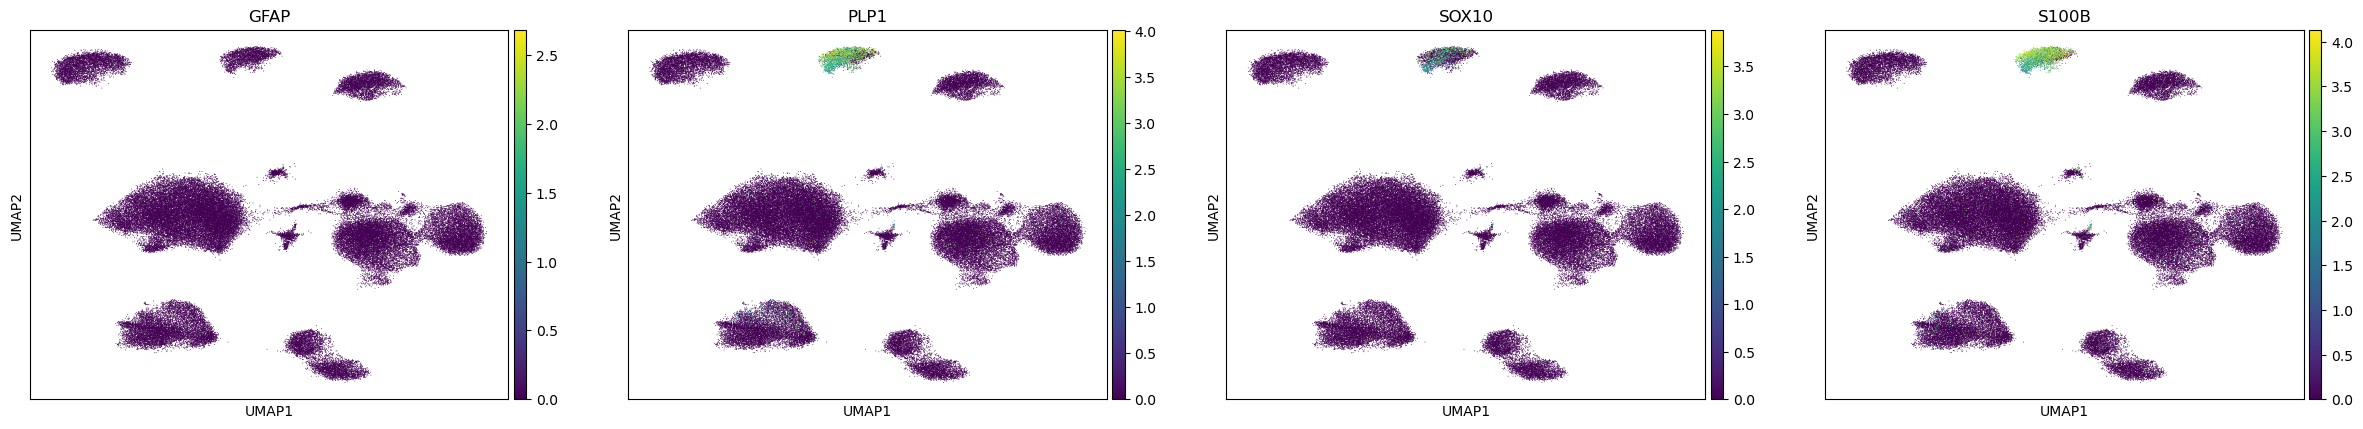

In [38]:
sc.pl.umap(
    adata_TI, 
    color=["GFAP", "PLP1", "SOX10", "S100B"], 
    use_raw=True  # raw 데이터 사용
)

In [30]:
gbarcodes = adata_TI[adata_TI.obs['cell_type'] == 'Glial cells'].obs_names
gbarcodes

Index([], dtype='object')

In [31]:
gadata_TI

AnnData object with n_obs × n_vars = 75695 × 28923
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'

In [32]:
gadata_TI.obs['batch'] = gadata_TI.obs_names.str.split('_').str[0]

In [33]:
sc.pp.highly_variable_genes(gadata_TI, n_top_genes=2000)
gadata_TI.raw = gadata_TI.copy()
gadata_TI = gadata_TI[:, gadata_TI.var.highly_variable].copy()

C:\Anaconda3\envs\NIM_Kim\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


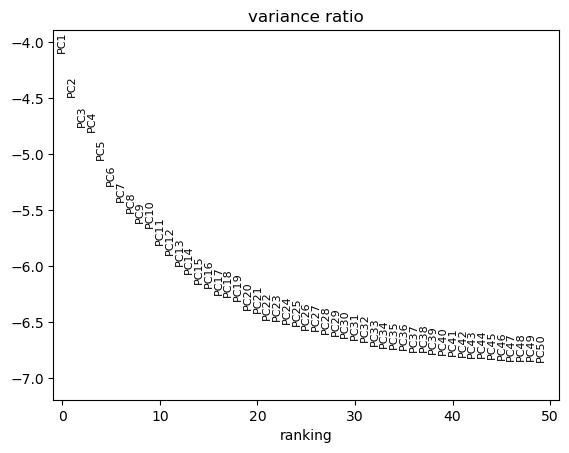

In [34]:
sc.pp.scale(gadata_TI, max_value=10)
sc.tl.pca(gadata_TI, svd_solver='arpack')
sc.pl.pca_variance_ratio(gadata_TI, log=True, n_pcs = 50)

In [35]:
sc.external.pp.harmony_integrate(gadata_TI, key='batch', max_iter_harmony = 20)
sc.pp.neighbors(gadata_TI, n_neighbors = 10, n_pcs = 15, use_rep='X_pca_harmony')
sc.tl.umap(gadata_TI)

2025-07-23 14:28:24,800 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-07-23 14:28:38,002 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-07-23 14:28:38,724 - harmonypy - INFO - Iteration 1 of 20
2025-07-23 14:30:00,620 - harmonypy - INFO - Iteration 2 of 20
2025-07-23 14:31:24,078 - harmonypy - INFO - Iteration 3 of 20
2025-07-23 14:32:46,221 - harmonypy - INFO - Iteration 4 of 20
2025-07-23 14:34:08,313 - harmonypy - INFO - Iteration 5 of 20
2025-07-23 14:35:30,504 - harmonypy - INFO - Iteration 6 of 20
2025-07-23 14:36:30,451 - harmonypy - INFO - Iteration 7 of 20
2025-07-23 14:37:38,293 - harmonypy - INFO - Iteration 8 of 20
2025-07-23 14:38:31,426 - harmonypy - INFO - Iteration 9 of 20
2025-07-23 14:39:35,926 - harmonypy - INFO - Converged after 9 iterations


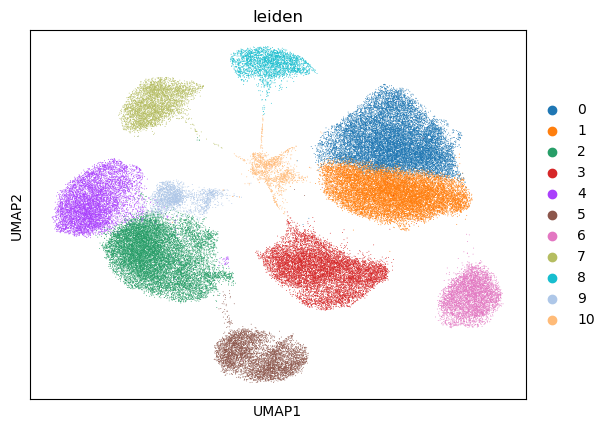

In [36]:
sc.tl.leiden(gadata_TI, resolution = 0.5)
sc.pl.umap(gadata_TI, color=['leiden'])

In [41]:
glial_markers = {
    "Neurogenic_primed": ["FABP7", "SOX2", "NESTIN"],
    "Immune_reactive": ["MHC2RA", "IL6", "CXCL10"],
    "ECM_rich": ["COL1A1", "FN1", "TNC"],
    "Schwann_like": ["MPZ", "PRX", "EGR2", "MBP"]
}

In [42]:
for ct, genes in glial_markers.items():
    valid_genes = [g for g in genes if g in gadata_TI.raw.var_names]
    sc.tl.score_genes(gadata_TI, gene_list=valid_genes, score_name=f"{ct}_score", use_raw=True)

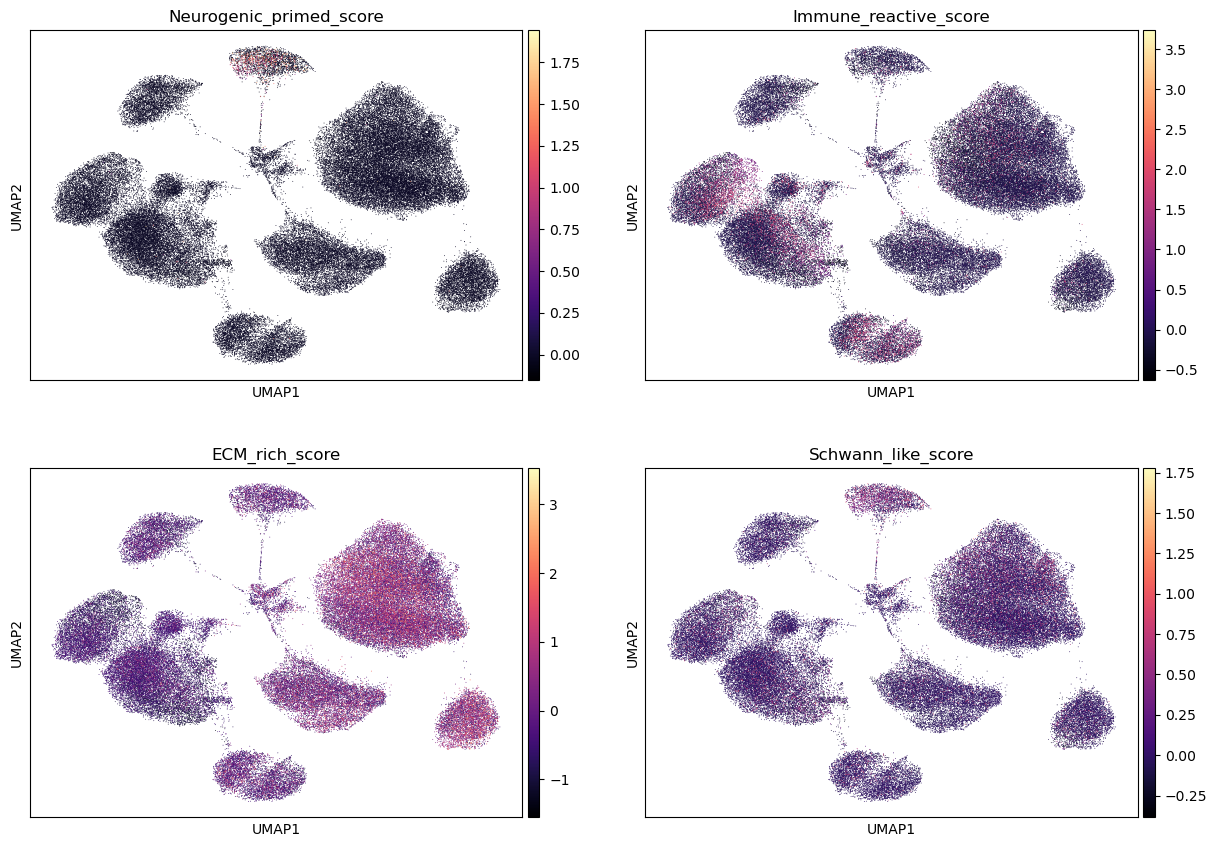

In [43]:
sc.pl.umap(gadata_TI, color=[f"{ct}_score" for ct in glial_markers], cmap="magma", ncols=2)

In [44]:
cluster_to_subtype = {}
for cluster in gadata_TI.obs['leiden'].unique():
    cluster_cells = gadata_TI[gadata_TI.obs['leiden'] == cluster]
    avg_scores = {ct: cluster_cells.obs[f"{ct}_score"].mean() for ct in glial_markers}
    best = max(avg_scores, key=avg_scores.get)
    cluster_to_subtype[cluster] = best
    print(f"Cluster {cluster}: {avg_scores} -> {best}")

gadata_TI.obs['glial_subtype'] = gadata_TI.obs['leiden'].map(cluster_to_subtype)

Cluster 0: {'Neurogenic_primed': np.float64(-0.01020464861120385), 'Immune_reactive': np.float64(-0.03279982934982829), 'ECM_rich': np.float64(0.06634523162238534), 'Schwann_like': np.float64(0.03476119306852954)} -> ECM_rich
Cluster 2: {'Neurogenic_primed': np.float64(-0.009904858892922924), 'Immune_reactive': np.float64(0.04003643321007797), 'ECM_rich': np.float64(-0.6183863822514675), 'Schwann_like': np.float64(-0.002886846901355948)} -> Immune_reactive
Cluster 3: {'Neurogenic_primed': np.float64(-0.008337183934233851), 'Immune_reactive': np.float64(-0.06476459900555766), 'ECM_rich': np.float64(-0.13578729342952164), 'Schwann_like': np.float64(-0.025955396722363466)} -> Neurogenic_primed
Cluster 1: {'Neurogenic_primed': np.float64(-0.00930120973646084), 'Immune_reactive': np.float64(-0.0758601670613442), 'ECM_rich': np.float64(0.0018187886329328836), 'Schwann_like': np.float64(-0.009341580489826666)} -> ECM_rich
Cluster 6: {'Neurogenic_primed': np.float64(-0.011089031988054299), 'Im

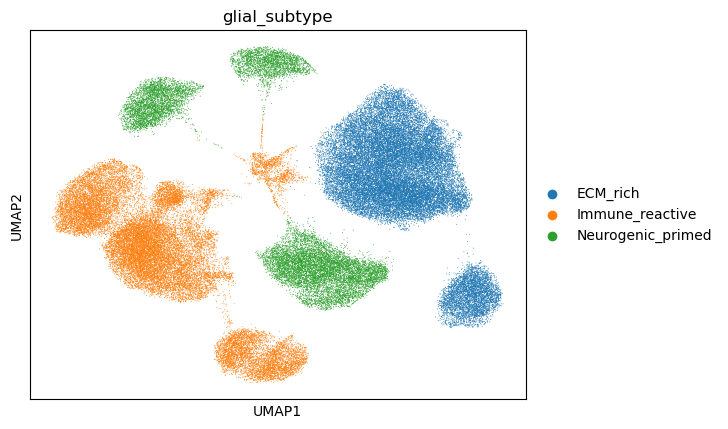

In [45]:
sc.pl.umap(gadata_TI, color='glial_subtype', legend_loc='right margin')